# Repulsive Spheres
In this example, spheres charackterized by individual masses and a radii $\sigma$ ar confined to a box and interact via Lennard-Jones potentials. Masses and radii of the spheres are recovered from the trajectories.

In [1]:
# For this System, depending on the GPU/CPU performance Cpu can be better, for our systems GPUs (e.g. a GTX 3070) where faster.
#import jax
#jax.config.update('jax_platform_name', 'cpu')

In [2]:
import jax.numpy as jnp
from jax import jit
from jax.flatten_util import ravel_pytree

import numpy as np
import scipy
import matplotlib.pyplot as plt

from adoptODE import train_adoptODE, simple_simulation

In [4]:
# Defining EOM for repulsive N-Body System
def n_body_eom_repulsive(**kwargs):
    r_box = kwargs['r_box']
    N_bodies = kwargs['N_bodies']
    def gen_params():
        masses = 9*np.random.rand(kwargs['N_bodies'])+1
        sigmas = 0.5*np.random.rand(kwargs['N_bodies'])+0.2
        return {'masses':masses, 'sigmas':sigmas}, {}, {}

    def gen_y0():
        one_dim_box = np.linspace(-r_box+0.2,r_box-0.2,int((2*r_box)//1.4))
        grid = np.meshgrid(*([one_dim_box]*3))
        slots = grid[0].size
        indcs = np.random.permutation(np.arange(slots))
        coords = np.stack([grid[i].flat[indcs[:N_bodies]] for i in range(3)], axis=1)
        vels = np.array(scipy.stats.truncnorm.rvs(-2,2, size=3*kwargs['N_bodies']).reshape((-1,3)))
        return {'positions':coords, 'velocities':vels}

    def eom(y,t,params, iparams, exparams):
        valid = 1-np.eye(kwargs['N_bodies'])
        dist_vecs = jnp.where(valid[:,:,jnp.newaxis]==1, 
                              (y['positions'] - y['positions'][:, jnp.newaxis]), 
                              jnp.ones_like(y['positions']))
        dists = jnp.linalg.norm(dist_vecs, axis=2)
        unit_dist_vecs = dist_vecs/dists[:,:,jnp.newaxis]
        dists = jnp.clip(dists, 1e-1, None)
        sigma_sum = params['sigmas'][jnp.newaxis, :, jnp.newaxis]+params['sigmas'][:, jnp.newaxis, jnp.newaxis]
        masses = params['masses'][:,jnp.newaxis,jnp.newaxis]
        LJ_acc = valid[:,:,jnp.newaxis]*unit_dist_vecs / masses*(24*sigma_sum**6*(dists[:,:,jnp.newaxis]**6-2*sigma_sum**6)/dists[:,:,jnp.newaxis]**13)

        pos_bound_lower = jnp.clip(-r_box-y['positions'],0, None)
        pos_bound_upper = jnp.clip(-r_box+y['positions'],0,None)
        bound_acc = 100*(pos_bound_lower**2 - pos_bound_upper**2)

        total_acc = jnp.sum(LJ_acc, axis=1) + bound_acc
        
        return {'positions': y['velocities'], 'velocities':total_acc}

    def loss(ys, params, iparams, exparams, ys_targets):
        loss_trajectory = jnp.nanmean((ravel_pytree(ys)[0]-ravel_pytree(ys_targets)[0])**2)
        return loss_trajectory

    return jit(eom), jit(loss), gen_params, gen_y0, {}

In [5]:
# Setting up dataset by simulation:
N_bodies = 10
t_evals = jnp.linspace(0,200,4000)
N_sys = 1
kwargs_sys = {'N_sys':N_sys, 'N_bodies':N_bodies, 'r_box':3.5*(N_bodies/10)**(1/3)}
reset_every = 20
t_reset_idcs = tuple([reset_every*i for i in range(int(np.ceil((len(t_evals)-1)/reset_every)))])
lower_bound_params = {'masses':1, 'sigmas':0.2}
kwargs_adoptODE = {'lr':1e-1, 
               'epochs':200, 
               't_reset_idcs':t_reset_idcs,
               'lr_decay':0.99, 
               'lower_b':lower_bound_params, 
               'atol':1e-7, 'rtol':1e-7}
dataset = simple_simulation(n_body_eom_repulsive, t_evals, kwargs_sys, kwargs_adoptODE)

In [6]:
# Performing Training:
params_final, losses, errors, params_history = train_adoptODE(dataset, print_interval=20)

Epoch 000:   Params Err.: 1.1e+01, y0 error: 0.0e+00, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 7.0e-01, 
Epoch 020:   Params Err.: 8.5e+00, y0 error: 0.0e+00, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 7.0e-03, 
Epoch 040:   Params Err.: 5.6e+00, y0 error: 0.0e+00, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.8e-03, 
Epoch 060:   Params Err.: 3.8e+00, y0 error: 0.0e+00, Params Norm: 2.0e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 7.6e-04, 
Epoch 080:   Params Err.: 3.6e+00, y0 error: 0.0e+00, Params Norm: 2.1e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 3.0e-04, 
Epoch 100:   Params Err.: 3.7e+00, y0 error: 0.0e+00, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.3e-04, 
Epoch 120:   Params Err.: 3.3e+00, y0 error: 0.0e+00, Params Norm: 2.2

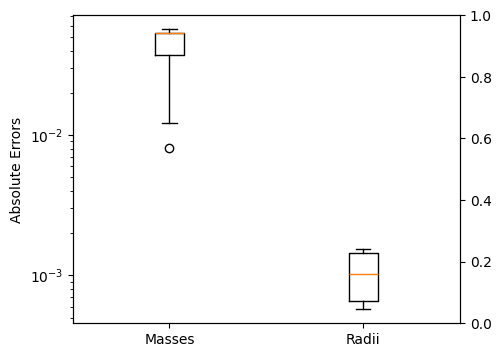

In [7]:
#Plot distribution of absolut errors:
fig, ax = plt.subplots(figsize=(5,4))
ax2 = ax.twinx()
ax.boxplot([np.abs(dataset.params['masses']-dataset.params_train['masses']), np.abs(dataset.params['sigmas']-dataset.params_train['sigmas'])])
ax.set_yscale('log')
ax.set_ylabel("Absolute Errors")
ax.set_xticklabels(['Masses', 'Radii'])
plt.show()

#### Longer training for better accuracy

In [8]:
N_bodies = 10
t_evals = jnp.linspace(0,200,4000)
N_sys = 1
kwargs_sys = {'N_sys':N_sys, 'N_bodies':N_bodies, 'r_box':3.5*(N_bodies/10)**(1/3)}
reset_every = 20
t_reset_idcs = tuple([reset_every*i for i in range(int(np.ceil((len(t_evals)-1)/reset_every)))])
lower_bound_params = {'masses':1, 'sigmas':0.2}
kwargs_adoptODE = {
          'lr': 3e-2,
          'epochs': 3000,
          't_reset_idcs': t_reset_idcs,
          'lr_decay': 0.9994,
          'lower_b': lower_bound_params,
          'atol': 1e-8,
          'rtol': 1e-8
      }
dataset = simple_simulation(n_body_eom_repulsive, t_evals, kwargs_sys, kwargs_adoptODE)

params_final, losses, errors, params_history = train_adoptODE(dataset, print_interval=20)

Epoch 000:   Params Err.: 1.0e+01, y0 error: 0.0e+00, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 3.6e-01, 
Epoch 020:   Params Err.: 9.4e+00, y0 error: 0.0e+00, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 5.3e-03, 
Epoch 040:   Params Err.: 8.0e+00, y0 error: 0.0e+00, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 3.4e-03, 
Epoch 060:   Params Err.: 6.6e+00, y0 error: 0.0e+00, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 2.3e-03, 
Epoch 080:   Params Err.: 5.3e+00, y0 error: 0.0e+00, Params Norm: 2.0e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.4e-03, 
Epoch 100:   Params Err.: 4.3e+00, y0 error: 0.0e+00, Params Norm: 2.0e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 7.9e-04, 
Epoch 120:   Params Err.: 3.2e+00, y0 error: 0.0e+00, Params Norm: 2.0

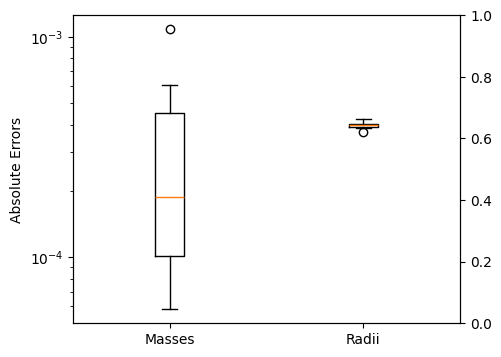

In [9]:
#Plot distribution of absolut errors:
fig, ax = plt.subplots(figsize=(5,4))
ax2 = ax.twinx()
ax.boxplot([np.abs(dataset.params['masses']-dataset.params_train['masses']), np.abs(dataset.params['sigmas']-dataset.params_train['sigmas'])])
ax.set_yscale('log')
ax.set_ylabel("Absolute Errors")
ax.set_xticklabels(['Masses', 'Radii'])
plt.show()